Import statements

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
       print(os.path.join(dirname, filename))

/kaggle/input/pytorch-summary-main/pytorch-summary-master/LICENSE
/kaggle/input/pytorch-summary-main/pytorch-summary-master/.gitignore
/kaggle/input/pytorch-summary-main/pytorch-summary-master/README.md
/kaggle/input/pytorch-summary-main/pytorch-summary-master/setup.py
/kaggle/input/pytorch-summary-main/pytorch-summary-master/torchsummary/torchsummary.py
/kaggle/input/pytorch-summary-main/pytorch-summary-master/torchsummary/__init__.py
/kaggle/input/pytorch-summary-main/pytorch-summary-master/torchsummary/tests/test_models/test_model.py
/kaggle/input/pytorch-summary-main/pytorch-summary-master/torchsummary/tests/unit_tests/torchsummary_test.py
/kaggle/input/project-files/df.lst
/kaggle/input/project-files/val3.lst
/kaggle/input/project-files/val.lst
/kaggle/input/project-files/fs.lst
/kaggle/input/project-files/nt.lst
/kaggle/input/checkpointfiles/checkpoint_dis.pth
/kaggle/input/checkpointfiles/checkpoint_gen_real.pth
/kaggle/input/checkpointfiles/checkpoint_gen_fake.pth
/kaggle/input

In [2]:
import os
import torch
import torch.utils.data as data
import torchvision
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.optim.optimizer import Optimizer
from torch.utils import model_zoo
import torch.optim
import cv2
from glob import glob
from tqdm import tqdm
import multiprocessing as mp
from functools import partial
import random
import numpy as np
from numpy.random import randint
import scipy
import scipy.ndimage
import math
import functools
from PIL import Image
import random
import collections
import re
import albumentations as A
from albumentations import Compose, RandomBrightnessContrast, \
    HorizontalFlip, FancyPCA, HueSaturationValue, OneOf, ToGray, \
    ShiftScaleRotate, ImageCompression, PadIfNeeded, GaussNoise, GaussianBlur
import pandas as pd

 **Assigning values to variables**

In [3]:

pretrain=True #use pretrained model
stride=2
fc_model=True #if it is fully connected network
norm_value=2.0 #norm value for stdv in pixel kernel generator
aug_after=True #use augumentations
gen_lr=2e-3 #learning rate of generator 2x10^-3
lr=5e-4 #learning rate of discriminator model 5x10^-4
weight_decay=5e-4 #parameter for weight decay
cls_num=2 #number of classes
segment_length=1
image_size=256
model_type="b5"
dropout_rate=0.4 #dropout rate for model
pretrain_name="/kaggle/input/efficientnet/adv-efficientnet-b5-86493f6b.pth" #model type for backbone
gen_blocks=3 #number of resnet block in generator
radius=3 #radius of the kernel
norm_type=nn.InstanceNorm2d #normalization 
kernel_channels=1 #single channel output map
learn_norm=True #learnable normalization parameter
no_clamp=True #it determines whether or not to clip the squared output values in generator forward pass
norm=True
val_acc = 0
max_epoch=6
batch_size=16
g_per_d=1
perm=True
lr_decay_factor=1e-1 #learn rate decay factor
lr_decay_epochs=5 #how many epochs the learn rate decay happen
workers=4

**DATA PREPROCESSING**

In [4]:

criterion = torch.nn.CrossEntropyLoss().cuda()

In [5]:
def create_train_transforms(size=320):
    return Compose([
      ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
        GaussNoise(p=0.1),
        HorizontalFlip(),
        PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
        OneOf([RandomBrightnessContrast(), FancyPCA(), HueSaturationValue()], p=0.7),
        ToGray(p=0.2),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    ]
    )

In [6]:
class FF_lst_dataset(data.Dataset):
    '''
    Items: [video_path, label, img_list]
    '''
    def __init__(self, annos, shuffle=True, phase = "TRAIN", transform=None, img_size=256, label='all'):

        super(FF_lst_dataset,self).__init__()

        self.annos = annos
        self.img_size = img_size
        self.phase = phase
        self.label = label
        self.tr =True

        if self.phase == 'TRAIN':
            self.tr = create_train_transforms(size=img_size)

        with open(annos) as f:
            frames = f.readlines()
        frames = [f.strip() for f in frames]
        self.frames = []
        if self.label == 'REAL' or self.label == 'FAKE':
            for f in frames:
                if f.endswith(self.label):
                    self.frames.append(f)
        else:
            self.frames = frames

        print('Dataset len: {}'.format(len(self.frames)))
        if shuffle:
            random.shuffle(self.frames)

        self.transform = transform

    def __getitem__(self, index):
        pth = self.frames[index]
        pth, label = pth.split(",")
        if os.path.exists(os.path.join(pth)):
          try:
                  img = Image.open(os.path.join(pth)).convert('RGB')
          except Exception as e:
                  print("Error in loading file")
          if self.phase == 'TRAIN' and self.tr:
            # add data aug ops
              img = np.asarray(img)
              img = self.tr(image=img)['image']
              img = Image.fromarray(img)

          label = 0 if label == 'FAKE' else 1
          if self.tr:
            img = self.transform(img)
          return img, label

    def __len__(self):
        return len(self.frames)


**DATASET LOADING**

In [7]:
crop=(256,256)

In [8]:
annotations="/kaggle/input/projectfiles/train.lst"
transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(crop),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])


In [9]:
val_annotations="/kaggle/input/project-files/val.lst"
val_transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(crop),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])
val_data = FF_lst_dataset(
                            val_annotations,
                            phase='TEST',
                            transform=val_transform,
                            img_size=256)
val_dataloader = torch.utils.data.DataLoader(dataset=val_data,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=workers,
                            drop_last=True)

Dataset len: 6000


In [10]:
train_data_real = FF_lst_dataset(
                                annotations,
                                phase='TRAIN',
                                transform=transform,
                                label='REAL',
                                img_size=256)
train_data_fake = FF_lst_dataset(
                                annotations,
                                phase='TRAIN',
                                transform=transform,
                                label='FAKE',
                                img_size=256)

Dataset len: 7000
Dataset len: 7000


In [11]:
dataloader_real = torch.utils.data.DataLoader(dataset=train_data_real,
                                            batch_size=batch_size//2,
                                            shuffle=True,
                                            num_workers=workers,
                                            drop_last=True)
dataloader_fake = torch.utils.data.DataLoader(dataset=train_data_fake,
                                            batch_size=batch_size//2,
                                            shuffle=True,
                                            num_workers=workers,
                                            drop_last=True)

**WEIGHT INTIALIZATION**

In [12]:
def init_weights(net, init_type='kaiming', init_gain=0.02):
    """Initialize network weights.

    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.

    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        """
        This line checks if the module has a weight attribute and if its class name contains either 'Conv' or 'Linear'.
        If both conditions are true, then the module is a convolutional layer or a linear layer that has weights that need to be initialized.
        """
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>
    return net


*ResNet Block*

In [13]:
class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out


*RAdam optimizer*

In [14]:
class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        #checks param is list or tuple and length is not less than 0 and first element of params is dictionary
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                # any change in betas values triggers a reset of the internal buffer represented by the 'buffer' key.
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                #If the gradient for a parameter is None, the loop continues to the next parameter.
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')
                #The state dictionary for the current parameter is retrieved.
                p_data_fp32 = p.data.float()
                """
                state management
                """
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    #existing state values are converted to float32 format if necessary.
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                # exp_avg_sq = beta2 * exp_avg_sq + (1 - beta2) * grad * grad.
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                #exp_avg = beta1 * exp_avg + (1 - beta1) * grad.
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss

**REAL AND FAKE GENERATOR**

Pixel kernel generator

In [15]:
class PixelKernelGenerator(nn.Module):
    def __init__(self, input_nc=3, output_nc=1, pert_channels=0, ngf=64, norm_layer=nn.InstanceNorm2d, use_dropout=False, n_blocks=0, padding_type='reflect', all=False, radius=3, use_bias=False, norm=False, learn_norm = False, no_clip=False, sigmoid=False):
        """Construct a Resnet-based generator
        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks, it should be 6/9
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(PixelKernelGenerator, self).__init__()
        self.eps = 1e-9
        self.all = all
        self.radius = radius
        self.use_bias = use_bias
        self.norm = norm
        self.learn_norm = learn_norm
        self.output_nc = output_nc
        self.pert_channels = pert_channels
        self.no_clip = no_clip
        # [100, 500]
        if self.learn_norm:
            self.new_norm = nn.Parameter(torch.tensor(100.0, dtype=torch.float32))
        else:
            self.new_norm = 100.0

        if self.use_bias:
            self.bias = nn.Parameter(torch.zeros(16, 1, 224, 224)).cuda()

        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        if self.all:
            model += [nn.Conv2d(ngf, output_nc*self.radius*self.radius, kernel_size=7, padding=0)]
        else:
            model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        # model += [nn.Tanh()]

        self.model = nn.Sequential(*model)


    def forward(self, x):
        x = self.model(x)
        x = x * x
        if self.all or self.no_clip:
            return x
        elif self.norm:
            # every sample a norm
            norm_value = torch.norm(x, p=2., dim=(1,2,3), keepdim=True)
            return x / norm_value * self.new_norm
        else:
            return torch.clamp(x, min=1, max=1e12)

In [16]:
def pixelKernelGenerator(input_nc=3, output_nc=1, pert_channels=0, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=0, padding_type='reflect', all=False, radius=3, use_bias=False, norm=False, learn_norm=False, no_clip=False):
    model = PixelKernelGenerator(input_nc=input_nc, output_nc=output_nc, pert_channels=pert_channels, ngf=ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=n_blocks, padding_type=padding_type, all=all, radius=radius, use_bias=use_bias, norm=norm, learn_norm=learn_norm, no_clip=no_clip)
    return init_weights(model)

In [17]:
model_gen_fake =pixelKernelGenerator(n_blocks=gen_blocks, radius=radius,norm_layer=norm_type, output_nc=kernel_channels, norm=norm, learn_norm=learn_norm,  no_clip=no_clamp)
model_gen_real =pixelKernelGenerator(n_blocks=gen_blocks, radius=radius,norm_layer=norm_type, output_nc=kernel_channels, norm=norm, learn_norm=learn_norm,  no_clip=no_clamp)


initialize network with kaiming
initialize network with kaiming


In [18]:
model_gen_real =nn.SyncBatchNorm.convert_sync_batchnorm(model_gen_real)
model_gen_real = model_gen_real.cuda()
model_gen_fake =nn.SyncBatchNorm.convert_sync_batchnorm(model_gen_fake)
model_gen_fake = model_gen_fake.cuda()

**Efficientnet model**

In [19]:

# Parameters for the entire model (stem, all blocks, and head)
GlobalParams = collections.namedtuple('GlobalParams', [
    'batch_norm_momentum', 'batch_norm_epsilon', 'dropout_rate',
    'num_classes', 'width_coefficient', 'depth_coefficient',
    'depth_divisor', 'min_depth', 'drop_connect_rate', 'image_size'])

# Parameters for an individual model block
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'stride', 'se_ratio'])

# Change namedtuple defaults
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


def round_filters(filters, global_params):
    """ Calculate and round number of filters based on depth multiplier. """
    multiplier = global_params.width_coefficient
    if not multiplier:
        return filters
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters:  # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """ Round number of filters based on depth multiplier. """
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


def drop_connect(inputs, p, training):
    """ Drop connect. """
    if not training: return inputs
    batch_size = inputs.shape[0]
    keep_prob = 1 - p
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)
    output = inputs / keep_prob * binary_tensor
    return output


def get_same_padding_conv2d(image_size=None):
    """ Chooses static padding if you have specified an image size, and dynamic padding otherwise.
        Static padding is necessary for ONNX exporting of models. """
    if image_size is None:
        return Conv2dDynamicSamePadding
    else:
        return partial(Conv2dStaticSamePadding, image_size=image_size)




class Conv2dDynamicSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a dynamic image size """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

    def forward(self, x):
        # kernel_diff = self.weight.sum(2).sum(2)
        # kernel_diff = kernel_diff[:, :, None, None]
        # out_diff = F.conv2d(x,kernel_diff,stride=self.stride, 
        #     padding=0,dilation=self.dilation,groups=self.groups) 
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)   #- 0.1 * out_diff


class Conv2dStaticSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a fixed image size"""

    def __init__(self, in_channels, out_channels, kernel_size, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = image_size if type(image_size) == list else [image_size, image_size]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = Identity()

    def forward(self, x):
        # kernel_diff = self.weight.sum(2).sum(2)
        # kernel_diff = kernel_diff[:, :, None, None]
        # out_diff = F.conv2d(x,kernel_diff,stride=self.stride, 
        #     padding=0,dilation=self.dilation,groups=self.groups) 
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x   #- 0.1 * out_diff


class Identity(nn.Module):
    def __init__(self, ):
        super(Identity, self).__init__()

    def forward(self, input):
        return input


########################################################################
############## HELPERS FUNCTIONS FOR LOADING MODEL PARAMS ##############
########################################################################


def efficientnet_params(model_name):
    """ Map EfficientNet model name to parameter coefficients. """
    params_dict = {
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
        'efficientnet-b8': (2.2, 3.6, 672, 0.5),
        'efficientnet-l2': (4.3, 5.3, 800, 0.5),
    }
    return params_dict[model_name]


class BlockDecoder(object):
    """ Block Decoder for readability, straight from the official TensorFlow repository """

    @staticmethod
    def _decode_block_string(block_string):
        """ Gets a block through a string notation of arguments. """
        assert isinstance(block_string, str)

        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        # Check stride
        assert (('s' in options and len(options['s']) == 1) or
                (len(options['s']) == 2 and options['s'][0] == options['s'][1]))

        return BlockArgs(
            kernel_size=int(options['k']),
            num_repeat=int(options['r']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            expand_ratio=int(options['e']),
            id_skip=('noskip' not in block_string),
            se_ratio=float(options['se']) if 'se' in options else None,
            stride=[int(options['s'][0])])

    @staticmethod
    def _encode_block_string(block):
        """Encodes a block to a string."""
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    @staticmethod
    def decode(string_list):
        """
        Decodes a list of string notations to specify blocks inside the network.
        :param string_list: a list of strings, each string is a notation of block
        :return: a list of BlockArgs namedtuples of block args
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args

    @staticmethod
    def encode(blocks_args):
        """
        Encodes a list of BlockArgs to a list of strings.
        :param blocks_args: a list of BlockArgs namedtuples of block args
        :return: a list of strings, each string is a notation of block
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings


def efficientnet1(width_coefficient=None, depth_coefficient=None, dropout_rate=0.2,
                 drop_connect_rate=0.2, image_size=None, num_classes=1000):
    """ Creates a efficientnet model. """

    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25', 'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25', 'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25', 'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    blocks_args = BlockDecoder.decode(blocks_args)

    global_params = GlobalParams(
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate,
        drop_connect_rate=drop_connect_rate,
        # data_format='channels_last',  # removed, this is always true in PyTorch
        num_classes=num_classes,
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        depth_divisor=8,
        min_depth=None,
        image_size=image_size,
    )

    return blocks_args, global_params


def get_model_params(model_name, override_params):
    """ Get the block args and global params for a given model """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        # note: all models have drop connect rate = 0.2
        blocks_args, global_params = efficientnet1(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError('model name is not pre-defined: %s' % model_name)
    if override_params:
        # ValueError will be raised here if override_params has fields not included in global_params.
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params


url_map = {
    'efficientnet-b0': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth',
    'efficientnet-b1': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth',
    'efficientnet-b2': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth',
    'efficientnet-b3': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth',
    'efficientnet-b4': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth',
    'efficientnet-b5': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth',
    'efficientnet-b6': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth',
    'efficientnet-b7': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth',
}


url_map_advprop = {
    'efficientnet-b0': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth',
    'efficientnet-b1': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b1-0f3ce85a.pth',
    'efficientnet-b2': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b2-6e9d97e5.pth',
    'efficientnet-b3': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b3-cdd7c0f4.pth',
    'efficientnet-b4': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b4-44fb3a87.pth',
    'efficientnet-b5': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b5-86493f6b.pth',
    'efficientnet-b6': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b6-ac80338e.pth',
    'efficientnet-b7': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b7-4652b6dd.pth',
    'efficientnet-b8': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b8-22a8fe65.pth',
}


def load_pretrained_weights(model, model_name, load_fc=True, advprop=False):
    """ Loads pretrained weights, and downloads if loading for the first time. """
    # AutoAugment or Advprop (different preprocessing)
    url_map_ = url_map_advprop if advprop else url_map
    state_dict = model_zoo.load_url(url_map_[model_name])
    if load_fc:
        model.load_state_dict(state_dict)
    else:
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')
        res = model.load_state_dict(state_dict, strict=False)
        assert set(res.missing_keys) == set(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
    print('Loaded pretrained weights for {}'.format(model_name))


*model building*

In [20]:
class MBConvBlock(nn.Module):
    """
    Mobile Inverted Residual Bottleneck Block
    Args:
        block_args (namedtuple): BlockArgs, see above
        global_params (namedtuple): GlobalParam, see above
    Attributes:
        has_se (bool): Whether the block contains a Squeeze and Excitation layer.
    """

    def __init__(self, block_args, global_params):
        super().__init__()
        self._block_args = block_args
        self._bn_mom = 1 - global_params.batch_norm_momentum
        self._bn_eps = global_params.batch_norm_epsilon
        self.has_se = (self._block_args.se_ratio is not None) and (0 < self._block_args.se_ratio <= 1)
        self.id_skip = block_args.id_skip  # skip connection and drop connect

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Expansion phase
        inp = self._block_args.input_filters  # number of input channels
        oup = self._block_args.input_filters * self._block_args.expand_ratio  # number of output channels
        if self._block_args.expand_ratio != 1:
            self._expand_conv = Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Depthwise convolution phase
        k = self._block_args.kernel_size
        s = self._block_args.stride
        self._depthwise_conv = Conv2d(
            in_channels=oup, out_channels=oup, groups=oup,  # groups makes it depthwise
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Squeeze and Excitation layer, if desired
        if self.has_se:
            num_squeezed_channels = max(1, int(self._block_args.input_filters * self._block_args.se_ratio))
            self._se_reduce = Conv2d(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2d(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        # Output phase
        final_oup = self._block_args.output_filters
        self._project_conv = Conv2d(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)
        self._swish = MemoryEfficientSwish()

    def forward(self, inputs, drop_connect_rate=None):
        """
        :param inputs: input tensor
        :param drop_connect_rate: drop connect rate (float, between 0 and 1)
        :return: output of block
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = self._swish(self._bn0(self._expand_conv(inputs)))
        x = self._swish(self._bn1(self._depthwise_conv(x)))

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(self._swish(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x

        x = self._bn2(self._project_conv(x))

        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export)"""
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()


In [21]:
class EfficientNet(nn.Module):
    """
    An EfficientNet model. Most easily loaded with the .from_name or .from_pretrained methods
    Args:
        blocks_args (list): A list of BlockArgs to construct blocks
        global_params (namedtuple): A set of GlobalParams shared between blocks
    Example:
        model = EfficientNet.from_pretrained('efficientnet-b0')
    """

    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self._global_params = global_params
        self._blocks_args = blocks_args

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        # Stem
        in_channels = 3  # rgb
        out_channels = round_filters(32, self._global_params)  # number of output channels
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Build blocks
        self._blocks = nn.ModuleList([])
        for block_args in self._blocks_args:

            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, self._global_params),
                output_filters=round_filters(block_args.output_filters, self._global_params),
                num_repeat=round_repeats(block_args.num_repeat, self._global_params)
            )

            # The first block needs to take care of stride and filter size increase.
            self._blocks.append(MBConvBlock(block_args, self._global_params))
            if block_args.num_repeat > 1:
                block_args = block_args._replace(input_filters=block_args.output_filters, stride=1)
            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params))

        # Head
        in_channels = block_args.output_filters  # output of final block
        out_channels = round_filters(1280, self._global_params)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(self._global_params.dropout_rate)
        # self._fc = nn.Linear(out_channels, self._global_params.num_classes)
        self._swish = MemoryEfficientSwish()

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export)"""
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()
        for block in self._blocks:
            block.set_swish(memory_efficient)


    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """

        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)

        # Head
        x = self._swish(self._bn1(self._conv_head(x)))
        # x = F.relu(self._bn1(self._conv_head(x)), inplace=True)

        return x

    def forward(self, inputs):
        """ Calls extract_features to extract features, applies final linear layer, and returns logits. """
        # bs = inputs.size(0)
        # Convolution layers
        x = self.extract_features(inputs)

        # # Pooling and final linear layer
        # x = self._avg_pooling(x)
        # x = x.view(bs, -1)
        # x = self._dropout(x)
        # x = self._fc(x)
        return x

    @classmethod
    def from_name(cls, model_name, override_params=None):
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        return cls(blocks_args, global_params)

    @classmethod
    def from_pretrained(cls, model_name, advprop=False, num_classes=1000, in_channels=3, image_size=224):
        model = cls.from_name(model_name, override_params={'num_classes': num_classes})
        # load_pretrained_weights(model, model_name, load_fc=(num_classes == 1000), advprop=advprop)
        # if in_channels != 3:
        #     Conv2d = get_same_padding_conv2d(image_size = model._global_params.image_size)
        #     out_channels = round_filters(32, model._global_params)
        #     model._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        return model

    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name):
        """ Validates model name. """
        valid_models = ['efficientnet-b'+str(i) for i in range(9)]
        if model_name not in valid_models:
            raise ValueError('model_name should be one of: ' + ', '.join(valid_models))


In [22]:
class ForensicNet(nn.Module):

    def __init__(self, num_classes=1000, segment_length=1, image_size=256, model_type='b5', dropout_rate=0.4):
        super(ForensicNet, self).__init__()
        self.input_size = image_size
        self.num_classes = num_classes
        self.segment_length = segment_length
        self.model_type = model_type
        self.dropout_rate = dropout_rate

        if model_type == 'b7':
            self.feature_model = EfficientNet.from_pretrained("efficientnet-b7",
                advprop=True,num_classes=self.num_classes,image_size=self.input_size)
            self.out_channels = 2560
        elif model_type == 'b3':
            self.feature_model = EfficientNet.from_pretrained("efficientnet-b3",
                advprop=True,num_classes=self.num_classes,image_size=self.input_size)
            self.out_channels = 1536
        else:
            self.feature_model = EfficientNet.from_pretrained("efficientnet-b5",
                advprop=True,num_classes=self.num_classes,image_size=self.input_size)
            self.out_channels = 2048

        # Final linear layer
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(self.dropout_rate)
        self._fc = nn.Linear(self.out_channels, num_classes)


    def forward(self, inputs, use_feature=False):
        bs = inputs.size(0)
        x = self.feature_model(inputs)
        # Pooling and final linear layer
        x = self._avg_pooling(x)
        x = x.view(bs, -1)
        if use_feature:
            return x
        x = self._dropout(x)
        x = self._fc(x)
        return x

    @property
    def crop_size(self):
        return self.input_size

In [23]:
def efficientnet(num_classes=1000,segment_length=1,image_size=256, model_type='b5', dropout_rate=0.4, pretrain=False, pretrain_name=None):
    model = ForensicNet(num_classes=num_classes, segment_length=segment_length, image_size=image_size, model_type=model_type, dropout_rate=dropout_rate)
    if model_type == 'b7':
        premodel = "/kaggle/input/efficientnet/adv-efficientnet-b7-4652b6dd.pth"
    elif model_type == 'b3':
        premodel = "/kaggle/input/efficientnet/adv-efficientnet-b3-cdd7c0f4.pth"
    else:
        premodel = "/kaggle/input/efficientnet/adv-efficientnet-b5-86493f6b.pth"

    premodel_dict = {}
    for k, v in torch.load(premodel).items():
        if k in model.feature_model.state_dict():
            premodel_dict[k] = v
    model.feature_model.load_state_dict(premodel_dict)
    return model

*Arguments*

In [24]:
model = efficientnet(cls_num,segment_length, image_size, model_type=model_type, dropout_rate=dropout_rate, pretrain=pretrain, pretrain_name=pretrain_name).cuda()
model = nn.SyncBatchNorm.convert_sync_batchnorm(model)
model = model.cuda()
crop_size = model.input_size

In [25]:
import zipfile
import os



os.chdir("/kaggle/input/pytorch-summary-main/pytorch-summary-master")


In [26]:
from torchsummary import summary

**Optimizer**

In [27]:
optimizer =RAdam(model.parameters(),lr=lr,weight_decay=weight_decay)
optimizer_gen_real = RAdam(model_gen_real.parameters(),lr=gen_lr,weight_decay=weight_decay)
optimizer_gen_fake =RAdam(model_gen_fake.parameters(),lr=gen_lr,weight_decay=weight_decay)

In [28]:
# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

In [29]:
model_gen_real = nn.DataParallel(model_gen_real)
model_gen_fake = nn.DataParallel(model_gen_fake)
model = nn.DataParallel(model)

**Necessary utils**

In [30]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    avg: avg of all losses/acc_rates
    val: current values of loss/acc_rate
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.
        self.avg = 0.
        self.sum = 0.
        self.count = 0.

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count > 0 else -1


*Adjusting learning rates*

In [31]:
def adjust_learning_rate_gen(optimizers, epoch, lr_factor, lr_steps):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr=2e-3
    weight_decay=5e-4
    decay = lr_factor ** (epoch // lr_steps)
    lr = gen_lr * decay
    weight_decay = weight_decay * decay
    for optimizer in optimizers:
        if optimizer is not None:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  #* param_group['lr_mult']
                param_group['weight_decay'] = weight_decay #* param_group['d

In [32]:
def adjust_learning_rate_dis(optimizers, epoch, lr_factor, lr_steps):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr=5e-4
    weight_decay=5e-4
    decay = lr_factor ** (epoch // lr_steps)
    lr = lr * decay
    weight_decay = weight_decay * decay
    for optimizer in optimizers:
        if optimizer is not None:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  #* param_group['lr_mult']
                param_group['weight_decay'] = weight_decay #* param_group['decay_mult']

*Pixelwise Gaussian Blur*

In [33]:
class PixelGaussian(nn.Module):
    def __init__(self, radius, image_size=256):
        super(PixelGaussian, self).__init__()
        assert (radius % 2) > 0, "Radius can not be even!"

        self.radius = radius
        self.image_size = image_size
        self.pad = nn.ReflectionPad2d(int((self.radius-1)//2))
        # init
        self.origin_weights = [[None for j in range(self.radius)] for i in range(self.radius)]
        a = radius // 2
        b = radius // 2
        for i in range(self.radius):
            for j in range(self.radius):
                # print(-((i-a)*(i-a) + (j-b)*(j-b))/2)
                """
                1- batch size(single image)
                3- no of channels(RGB)
                img_size x img_size- dimensions
                This creates a tensor of size (1, 3, image_size, image_size) filled with the value -((i-a)*(i-a) + (j-b)*(j-b))/2.
                """
                self.origin_weights[i][j] = torch.full((1, 3, image_size, image_size), -((i-a)*(i-a) + (j-b)*(j-b))/2, dtype=torch.float32).cuda()
                # print(self.origin_weights[i][j][0, 0, 0, 0])
        # self.weights_init(radius, sigma)

    def forward(self, x, sigma):
        """
        b- batch size of images
        s- no of samples needed
        """
        # x.shape: b*s, 3, 224, 224
        # sigma: b*s, 1, 224, 224
        # self.tmp_weight[i][j].shape: b*s, 3, 224, 224
        self.tmp_weight = self.weights_init(sigma, x)

        result = torch.zeros_like(x)
        x = self.pad(x)
        # print(x.shape)
        for i in range(self.radius):
            for j in range(self.radius):
                """
                performs the convolution operation between the input tensor x and the Gaussian weights self.tmp_weight[i][j] for each position in the kernel.
                """
                result += x[:, :, i:i+self.image_size, j:j+self.image_size] * self.tmp_weight[i][j]
        return result

    def weights_init(self, sigma, x):
        tmp = [[None for j in range(self.radius)] for i in range(self.radius)]
        for i in range(self.radius):
            for j in range(self.radius):
                # tmp[i][j] = torch.exp(self.origin_weights[i][j].expand(x.shape[0], -1, -1, -1) * sigma * sigma)
                """
                calculates the Gaussian weights for each position in the kernel and applies an exponential function to them.
                """
                tmp[i][j] = torch.exp(self.origin_weights[i][j].expand(x.shape[0], -1, -1, -1) * sigma)
                if i == 0 and j == 0:
                    tmp_sum = tmp[i][j].clone()
                else:
                    tmp_sum += tmp[i][j]

        for i in range(self.radius):
            for j in range(self.radius):
                tmp[i][j] = tmp[i][j] / tmp_sum
        """
        These weights will be used in the convolution operation during the forward pass of the model.
        """
        return tmp


Data Augmentation

In [34]:
def DiffAugment2(x, policy='', channels_first=True):
    policys = ['color', 'translation', 'cutout']
    for p in policys:
        if random.random() < AUGMENT_PROP[p]:
            if p == 'color':
                f = random.choices(AUGMENT_FNS[p], k=1)[0]
                x = f(x)
            else:
                x = AUGMENT_FNS[p][0](x)
    x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    x = x.clamp_(-1, 1)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    x = x.clamp_(-1, 1)
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    x = x.clamp_(-1, 1)
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'color1': [rand_brightness],
    'color2': [rand_saturation],
    'color3': [rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

AUGMENT_PROP = {
    'color': 0.7,
    'color1': 0.7,
    'color2': 0.7,
    'color3': 0.7,
    'translation': 0.5,
    'cutout': 0.5,
}

VALID_AUG = set(['color', 'translation', 'cutout'])


Virtual Adversarial Training

In [35]:
def virtual_adversarial_loss(model, x, logit):
    epsilon = 1.0  # Small perturbation size
    xi = 1e-6  # Random perturbation
    vat_coef=0.01
    d = torch.randn_like(x).uniform_(-1, 1).requires_grad_()  # Create random perturbation
    for _ in range(1):  # Number of power iteration steps (can be adjusted)
        logit_m = model(x + xi * torch.tanh(d))
        logit_m = logit_m.to(torch.float32)
        logit = logit.to(torch.float32)
        #print("Shape of logit_m:", logit_m.shape)
        #print("Shape of logit:", logit.shape)
        logit_m_softmax = nn.LogSoftmax(dim=-1)(logit_m)
        logit_softmax = nn.LogSoftmax(dim=-1)(logit)
        logit_softmax = logit_softmax.unsqueeze(1)
        #print("Shape of logit_m_softmax:", logit_m_softmax.size())
        #print("Shape of logit_softmax:", logit_softmax.size())

        # Calculate Kullback-Leibler Divergence Loss
        dist = torch.sum(torch.exp(logit_m_softmax) * (logit_m_softmax - logit_softmax), dim=1)
        adv_distance = torch.mean(dist)


        # Compute gradient
        grad = torch.autograd.grad(adv_distance, [d])[0]

        # Update perturbation with gradient ascent
        d = torch.clamp(d + epsilon * torch.tanh(grad), min=-1, max=1)
        d = d.detach()

    logit_p = model(x + xi * torch.tanh(d))
    logit_p_softmax = nn.LogSoftmax(dim=1)(logit_p)

    # Calculate adversarial distance after perturbation updates
    dist = torch.sum(torch.exp(logit_p_softmax) * (logit_p_softmax - logit_softmax), dim=1)
    adv_distance = torch.mean(dist)
    return adv_distance*vat_coef

**Training and Testing**

In [36]:
def train(train_loaders, criterion, models, optimizers, epoch, segment_length, val_dataloader=None, args=None):
    global val_acc,checkpoint_dis ,checkpoint_gen_real,checkpoint_gen_fake
    dislosses = AverageMeter()
    dislosses_input_real = AverageMeter()
    dislosses_input_fake = AverageMeter()
    dislosses_gen_real = AverageMeter()
    dislosses_gen_fake = AverageMeter()
    gen_real_losses = AverageMeter()
    gen_fake_losses = AverageMeter()
    vat_loss_real =AverageMeter()
    vat_loss_fake =AverageMeter()
    checkpoint_path_dis='/kaggle/working/checkpoint_dis.pth'
    accuracies = AverageMeter()
    sft = nn.Softmax(-1)
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    
    model_dis, model_gen_real, model_gen_fake = models
    optimizer_dis, optimizer_gen_real, optimizer_gen_fake = optimizers
    train_loader_real, train_loaders_fake = train_loaders
    
        
    model_dis.train()
    model_gen_real.train()
    model_gen_fake.train()
    real_all, real_right = 0, 0
    fake_all, fake_right = 0, 0
    img_all, img_right = 0, 0
    gaussian = PixelGaussian(radius=radius, image_size=crop_size).cuda()
    for i, ((inputs_real, targets_real), (inputs_fake, targets_fake)) in enumerate(zip(train_loader_real, train_loaders_fake)):
        print("Batch Number",i+1)
        # Cast inputs and labels to half-precision
        inputs_real= inputs_real.half().to(device='cuda')
        targets_real = targets_real.to(torch.int64)
        inputs_fake= inputs_fake.half().to(device='cuda')
        targets_fake= targets_fake.to(torch.int64)

        
        #32- pooling window/kernel size
        b, c, w, h = list(inputs_real.size()) #batch,channels,width,height
        w_out, h_out = math.ceil(w/32/stride), math.ceil(h/32/stride)
        targets_real = targets_real.cuda()
        targets_fake = targets_fake.cuda()

        if fc_model:
            #This checks if the model is a fully convolutional network
            targets_aug_real = targets_real.clone()

            targets_aug_fake = targets_fake.clone()
        else:
            #add dimension to the tensor
            targets_aug_real = targets_real.unsqueeze(-1)
            #This essentially creates multiple copies of the target labels for each pixel in the generated image.
            targets_aug_real = targets_aug_real.repeat(1,int(w_out*h_out)).view(-1)
            targets_aug_fake = targets_fake.unsqueeze(-1)
            targets_aug_fake = targets_aug_fake.repeat(1,int(w_out*h_out)).view(-1)

            #This reshapes the real input data to the expected format (batch size, number of channels, width, and height) and moves it to the GPU.

        inputs_real = inputs_real.view(b, c, w, h).cuda()
        inputs_fake = inputs_fake.view(b, c, w, h).cuda()
        # train gen model
        model_gen_real.train()
        model_gen_fake.train()
        model_dis.eval()
        for param in model_dis.parameters():
            param.requires_grad = False
        for g_num in range(g_per_d):
                # real model
                optimizer_gen_real.zero_grad()
                with torch.cuda.amp.autocast():
                  sigmas_real = model_gen_real(inputs_real)
                  generations_real = gaussian(inputs_real, sigmas_real).float()
                  gen_real_op=model_dis(generations_real)
                  gen_blur_real_loss =criterion(gen_real_op, targets_aug_real).mean()
                  vat_loss_real = virtual_adversarial_loss(model_dis, generations_real, gen_real_op)
                  genloss_real = gen_blur_real_loss+vat_loss_real  # Combine original and VAT loss
                  # Backward pass and optimization
                scaler.scale(genloss_real).backward()
                torch.nn.utils.clip_grad_norm_(model_gen_real.parameters(), max_norm=1.0)
                scaler.step(optimizer_gen_real)
                scaler.update()
                

                # fake model
                optimizer_gen_fake.zero_grad()
                with torch.cuda.amp.autocast():
                  sigmas_fake = model_gen_fake(inputs_fake)
                  generations_fake = gaussian(inputs_fake, sigmas_fake).float()
                  gen_fake_op=model_dis(generations_fake)
                  gen_blur_fake_loss =criterion(gen_fake_op, targets_aug_fake).mean()
                  vat_loss_fake = virtual_adversarial_loss(model_dis, generations_fake, gen_fake_op)
                  genloss_fake = gen_blur_fake_loss+vat_loss_fake  # Combine original and VAT loss
                  # Backward pass and optimization
                scaler.scale(genloss_fake).backward()
                torch.nn.utils.clip_grad_norm_(model_gen_fake.parameters(), max_norm=.0)
                scaler.step(optimizer_gen_fake)
                scaler.update()


        #generations_real=generations_real_tmp
        #generations_fake=generations_fake_tmp
        # train dis model
        model_dis.train()
        for param in model_dis.parameters():
            param.requires_grad = True
        # # add diffaugmentation to inputs and generations
        if aug_after:
            generations_real = DiffAugment2(generations_real)
            generations_fake = DiffAugment2(generations_fake)
            inputs_real = DiffAugment2(inputs_real)
            inputs_fake = DiffAugment2(inputs_fake)
        generations = torch.cat([generations_real, generations_fake])
        generations = generations.detach()
        inputs = torch.cat([inputs_real, inputs_fake])
        targets_aug = torch.cat([targets_aug_real, targets_aug_fake])
        targets = torch.cat([targets_real, targets_fake])
        # calculate 4 kinds of loss
        model_dis.eval()
        with torch.no_grad():
           with torch.cuda.amp.autocast():
            # inputs real loss
              pred_inputs_real = model_dis(inputs_real)
              disloss_inputs_real = criterion(pred_inputs_real, targets_aug_real).mean()
            # inputs fake loss
              pred_inputs_fake = model_dis(inputs_fake)
              disloss_inputs_fake = criterion(pred_inputs_fake, targets_aug_fake).mean()
            # gen real loss
              pred_gen_real = model_dis(generations_real)
              disloss_gen_real = criterion(pred_gen_real, targets_aug_real).mean()
             # gen fake loss
              pred_gen_fake = model_dis(generations_fake)
              disloss_gen_fake = criterion(pred_gen_fake, targets_aug_fake).mean()
        model_dis.train()
        optimizer_dis.zero_grad()
        both_imgs = torch.cat([inputs, generations], dim=0)
        targets_aug = torch.cat([targets_aug, targets_aug], dim=0)
        targets = torch.cat([targets, targets], dim=0)
        if perm:
            perms = torch.randperm(both_imgs.size(0), device=both_imgs.device)
            both_imgs = both_imgs[perms]
            targets_aug = targets_aug.view(both_imgs.size(0), -1)
            targets_aug = targets_aug[perms]
            targets_aug = targets_aug.reshape(-1)
            targets = targets[perms]
        inputs_to_dis = both_imgs
        with torch.cuda.amp.autocast():
          pred = model_dis(inputs_to_dis)
          disloss = criterion(pred, targets_aug).mean()
        # Backward pass and optimization
        scaler.scale(disloss).backward()
        torch.nn.utils.clip_grad_norm_(model_dis.parameters(), max_norm=1.0)
        scaler.step(optimizer_dis)
        scaler.update()
        pred = sft(pred)
        pred_final = pred.view(b*4,-1,cls_num).sum(1).data

        pred_final = pred_final.argmax(dim=-1)

        right = float(torch.sum(pred_final==targets))
        right_real = float(torch.sum((pred_final == targets) * (targets == 1)))
        num_real = float(torch.sum(targets == 1))
        right_fake = float(torch.sum((pred_final == targets) * (targets == 0)))
        num_fake = float(torch.sum(targets == 0))

        img_all += targets.shape[0]
        img_right += right
        real_all += num_real
        real_right += right_real
        dislosses.update(disloss.item(), targets.size(0))
        accuracies.update(right/targets.size(0), targets.size(0))

        gen_real_losses.update(genloss_real.item(), targets.size(0)//4)
        gen_fake_losses.update(genloss_fake.item(), targets.size(0)//4)

        dislosses_input_real.update(disloss_inputs_real.item(), targets.size(0)//4)
        dislosses_input_fake.update(disloss_inputs_fake.item(), targets.size(0)//4)
        dislosses_gen_real.update(disloss_gen_real.item(), targets.size(0)//4)
        dislosses_gen_fake.update(disloss_gen_fake.item(), targets.size(0)//4)


        fake_all += num_fake
        fake_right += right_fake
        print('real-accuracy.avg: {}, fake-accuracy.avg: {}.'.format(100*real_right/real_all if real_all else 0, 100*fake_right/fake_all if fake_all else 0))

        print('Gen real loss:',gen_real_losses.avg,' Gen fake loss:',gen_fake_losses.avg)
        print('Dis losses:')
        print('Input_real:', dislosses_input_real.avg,' Input_fake:',dislosses_input_fake.avg,' Gen_real:',dislosses_gen_real.avg,' Gen_fake',dislosses_gen_fake.avg)
    # start val,
    model_dis.eval()
    for param in model_dis.parameters():
        param.requires_grad = False
    dislosses_val = AverageMeter()
    accuracies = AverageMeter()
    val_real_all, val_real_right = 0, 0
    val_img_all, val_img_right = 0, 0
    val_fake_all, val_fake_right = 0, 0
    val_real_wrong,val_fake_wrong=0,0
    for inputs, targets in val_dataloader:
        # print('-', end='')
        b, c, w, h = list(inputs.size())
        w_out, h_out = math.ceil(w/32/stride), math.ceil(h/32/stride)
        inputs = inputs.view(b, c, w, h)
        inputs = inputs.half().to(device='cuda')
        targets=targets.to(torch.int64).cuda()
        if fc_model:
            targets_aug = targets
        else:
            targets_aug = targets
        '''elif mean:
            targets_aug = targets.unsqueeze(-1)
            targets_aug = targets_aug.repeat(1,int(w_out*h_out)).view(-1)'''
        
        with torch.cuda.amp.autocast():
            outputs = model_dis(inputs)
            loss = criterion(outputs, targets_aug).mean()
        dislosses_val.update(loss.item(), targets.size(0))
        outputs = outputs.softmax(dim=-1)

        
        outputs = outputs.view(b,-1,cls_num).mean(1).data

        pred_final = outputs.argmax(dim=-1)
        right = float(torch.sum(pred_final==targets))
        right_real = float(torch.sum((pred_final == targets) * (targets == 1)))#true positive
        num_real = float(torch.sum(targets == 1))
        wrong_fake=float(torch.sum((pred_final != targets) * (targets == 1)))#false negative
        wrong_real=float(torch.sum((pred_final != targets) * (targets == 0)))#false positive
        right_fake = float(torch.sum((pred_final == targets) * (targets == 0)))#true negative
        num_fake = float(torch.sum(targets == 0))

        val_img_all += targets.shape[0]
        val_img_right += right #TN +TP
        val_real_all += num_real #positive
        val_real_right += right_real #TP
        val_real_wrong+=wrong_real#FP
        accuracies.update(right/targets.size(0), targets.size(0))
        val_fake_all += num_fake#negative
        val_fake_right += right_fake#TN
        val_fake_wrong+=wrong_fake#FN

    acc.append(100*val_img_right/val_img_all)
    if((val_real_right+val_real_wrong)==0):
      p=0
    else:
      p=100*(val_real_right/(val_real_right+val_real_wrong))
    precision.append(p)
    if((val_real_right+val_fake_wrong)==0):
      r=0
    else:
      r=100*(val_real_right/(val_real_right+val_fake_wrong))
    recall.append(r)
    if(r!=0 and p!=0):
      fscore.append((2*((p*r)/(p+r))))
    else:
      fscore.append(0)



    print('----------------------------------------------------------------') 
    val_acc_tmp = 100*val_img_right/val_img_all
    if val_acc_tmp > val_acc:
        val_acc = val_acc_tmp
        print('Save best model at Epoch : {}, best acc: {}'.format(epoch+1, val_acc))        
        print("val accuracy:",val_acc)
        checkpoint_path_dis ='/kaggle/working/checkpoint_dis.pth'
        os.makedirs(os.path.dirname(checkpoint_path_dis), exist_ok=True)
        checkpoint_dis={
            'epoch':epoch,
            'model_state_dict':model_dis.state_dict(),
            'optimizer_state_dict':optimizer_dis.state_dict(),
            'val_acc':val_acc
        }
        torch.save(checkpoint_dis,checkpoint_path_dis)
    # print val message
    print('Val on val-set, Epoch: {}, val_loss: {}, acc: {}, real-acc: {}, '.format(epoch+1, dislosses_val.avg, 100*val_img_right/val_img_all, 100*val_real_right/val_real_all), end=' ')
    print('fake-acc: {}'.format(100*val_fake_right/val_fake_all))
    checkpoint_path_gen_real = '/kaggle/working/checkpoint_gen_real.pth'
    os.makedirs(os.path.dirname(checkpoint_path_gen_real), exist_ok=True)
    checkpoint_gen_real={
            'model_state_dict':model_gen_real.state_dict(),
            'optimizer_state_dict':optimizer_gen_real.state_dict(),
            
        }
  
    checkpoint_path_gen_fake = '/kaggle/working/checkpoint_gen_fake.pth'
    os.makedirs(os.path.dirname(checkpoint_path_gen_fake), exist_ok=True)
    checkpoint_gen_fake={
            'model_state_dict':model_gen_fake.state_dict(),
            'optimizer_state_dict':optimizer_gen_fake.state_dict(),
            
        }
    torch.save(checkpoint_gen_fake,'/kaggle/working/checkpoint_gen_fake.pth')
    model_dis.train()
    for param in model_dis.parameters():
        param.requires_grad = True

In [37]:

acc=[]
precision=[]
recall=[]
fscore=[]
checkpoint_path_dis='/kaggle/input/checkpointfiles/checkpoint_dis.pth'
dis_file='checkpoint_dis.pth'
if os.path.exists(checkpoint_path_dis):
            checkpoint_dis= torch.load(checkpoint_path_dis)
            model.load_state_dict(checkpoint_dis['model_state_dict'])
            optimizer.load_state_dict(checkpoint_dis['optimizer_state_dict'])
            val_acc=checkpoint_dis['val_acc']
checkpoint_path_gen_real='/kaggle/input/checkpointfiles/checkpoint_gen_real.pth'
if os.path.exists(checkpoint_path_gen_real):
            checkpoint_gen_real= torch.load(checkpoint_path_gen_real)
            model_gen_real.load_state_dict(checkpoint_gen_real['model_state_dict'])
            optimizer_gen_real.load_state_dict(checkpoint_gen_real['optimizer_state_dict'])
checkpoint_path_gen_fake='/kaggle/input/checkpointfiles/checkpoint_gen_fake.pth'
if os.path.exists(checkpoint_path_gen_fake):
            checkpoint_gen_fake= torch.load(checkpoint_path_gen_fake)
            model_gen_fake.load_state_dict(checkpoint_gen_fake['model_state_dict'])
            optimizer_gen_fake.load_state_dict(checkpoint_gen_fake['optimizer_state_dict'])
for epoch in range(0,0):
        print("________________________________________________________EPOCH : ",epoch,"______________________________________________________")
        adjust_learning_rate_dis([optimizer],  epoch,lr_decay_factor, lr_decay_epochs)
        adjust_learning_rate_gen([optimizer_gen_real], epoch, lr_decay_factor, lr_decay_epochs)
        adjust_learning_rate_gen([optimizer_gen_fake], epoch, lr_decay_factor, lr_decay_epochs)
        train([dataloader_real, dataloader_fake], criterion, [model, model_gen_real, model_gen_fake], [optimizer, optimizer_gen_real, optimizer_gen_fake], epoch,segment_length, val_dataloader=val_dataloader)
        torch.cuda.empty_cache()
torch.save(checkpoint_gen_real,'/kaggle/working/checkpoint_gen_real.pth')
torch.save(checkpoint_gen_fake,'/kaggle/working/checkpoint_gen_fake.pth')


In [38]:

no=[i+1 for i in range(0,0)]
metrics_table=pd.DataFrame(
    {
        'Epoch':no,
        'Precision':precision,
        'Recall':recall,
        'Accuracy':acc,
        'F1_Score':fscore
    }
)
metrics_table


,Epoch,Precision,Recall,Accuracy,F1_Score


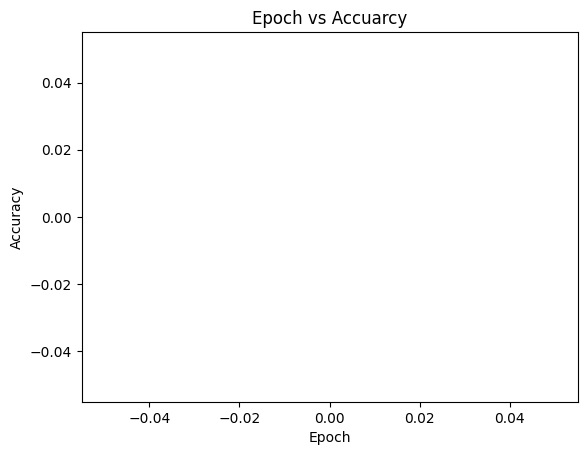

In [39]:
import matplotlib.pylab as plt
plt.plot(no,acc,"-o")
plt.title("Epoch vs Accuarcy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [40]:
df_annotations="/kaggle/input/projectfiles/df.lst"
df_transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(crop),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])
df_data = FF_lst_dataset(
                            df_annotations,
                            phase='TEST',
                            transform=df_transform,
                            img_size=256)
df_dataloader = torch.utils.data.DataLoader(dataset=df_data,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=workers,
                            drop_last=True)

Dataset len: 6000


In [41]:
def evaluate(criterion, model, deepfake_dataloader=None):

    model_dis = model

    # start val,
    model_dis.eval()
    for param in model_dis.parameters():
        param.requires_grad = False
    dislosses_val = AverageMeter()
    accuracies = AverageMeter()
    val_real_all, val_real_right = 0, 0
    val_img_all, val_img_right = 0, 0
    val_fake_all, val_fake_right = 0, 0
    val_real_wrong,val_fake_wrong=0,0
    for inputs, targets in deepfake_dataloader:
        # print('-', end='')
        b, c, w, h = list(inputs.size())
        inputs = inputs.view(b, c, w, h)
        inputs = inputs.half().to(device='cuda')
        targets=targets.to(torch.int64).cuda()
        if fc_model:
            targets_aug = targets
        else:
            targets_aug = targets
        '''elif mean:
            targets_aug = targets.unsqueeze(-1)
            targets_aug = targets_aug.repeat(1,int(w_out*h_out)).view(-1)'''
        
        with torch.cuda.amp.autocast():
            outputs = model_dis(inputs)
            loss = criterion(outputs, targets_aug).mean()
        dislosses_val.update(loss.item(), targets.size(0))
        outputs = outputs.softmax(dim=-1)

        
        outputs = outputs.view(b,-1,cls_num).mean(1).data

        pred_final = outputs.argmax(dim=-1)
        right = float(torch.sum(pred_final==targets))
        right_real = float(torch.sum((pred_final == targets) * (targets == 1)))#true positive
        num_real = float(torch.sum(targets == 1))
        wrong_fake=float(torch.sum((pred_final != targets) * (targets == 1)))#false negative
        wrong_real=float(torch.sum((pred_final != targets) * (targets == 0)))#false positive
        right_fake = float(torch.sum((pred_final == targets) * (targets == 0)))#true negative
        num_fake = float(torch.sum(targets == 0))

        val_img_all += targets.shape[0]
        val_img_right += right #TN +TP
        val_real_all += num_real #positive
        val_real_right += right_real #TP
        val_real_wrong+=wrong_real#FP
        accuracies.update(right/targets.size(0), targets.size(0))
        val_fake_all += num_fake#negative
        val_fake_right += right_fake#TN
        val_fake_wrong+=wrong_fake#FN

    print('Accuracy:',100*val_img_right/val_img_all)
    if((val_real_right+val_real_wrong)==0):
      p=0
    else:
      p=100*(val_real_right/(val_real_right+val_real_wrong))
    print('Precision:',p)
    if((val_real_right+val_fake_wrong)==0):
      r=0
    else:
      r=100*(val_real_right/(val_real_right+val_fake_wrong))
    print('Recall:',r)
    if(r!=0 and p!=0):
      print('Fscore',(2*((p*r)/(p+r))))
    else:
      print('Fscore',0)



    print('----------------------------------------------------------------')     
    print('Deepfake:  acc: {}, real-acc: {}, '.format( 100*val_img_right/val_img_all, 100*val_real_right/val_real_all), end=' ')
    print('fake-acc: {}'.format(100*val_fake_right/val_fake_all))

In [42]:
df_annotations="/kaggle/input/projectfiles/df-org.lst"
df_transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(crop),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])
df_data = FF_lst_dataset(
                            df_annotations,
                            phase='TEST',
                            transform=df_transform,
                            img_size=256)
df_dataloader = torch.utils.data.DataLoader(dataset=df_data,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=workers,
                            drop_last=True)
evaluate(criterion, model, df_dataloader)

Dataset len: 400
Accuracy: 50.25
Precision: 42.64264264264264
Recall: 94.66666666666667
Fscore 58.79917184265011
----------------------------------------------------------------
Deepfake:  acc: 50.25, real-acc: 94.66666666666667,  fake-acc: 23.6


In [43]:
df_annotations="/kaggle/input/projectfiles-com/com_df.lst"
df_transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(crop),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])
df_data = FF_lst_dataset(
                            df_annotations,
                            phase='TEST',
                            transform=df_transform,
                            img_size=256)
df_dataloader = torch.utils.data.DataLoader(dataset=df_data,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=workers,
                            drop_last=True)
evaluate(criterion, model, df_dataloader)

Dataset len: 500
Accuracy: 60.08064516129032
Precision: 55.53047404063205
Recall: 99.59514170040485
Fscore 71.30434782608695
----------------------------------------------------------------
Deepfake:  acc: 60.08064516129032, real-acc: 99.59514170040485,  fake-acc: 20.883534136546185


In [44]:
annotations="/kaggle/input/projectfiles/nt-org.lst"
transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(crop),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])
data = FF_lst_dataset(
                            annotations,
                            phase='TEST',
                            transform=df_transform,
                            img_size=256)
nt_dataloader = torch.utils.data.DataLoader(dataset=data,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=workers,
                            drop_last=True)
evaluate(criterion, model, nt_dataloader)

Dataset len: 400
Accuracy: 39.0
Precision: 37.56613756613756
Recall: 94.66666666666667
Fscore 53.78787878787879
----------------------------------------------------------------
Deepfake:  acc: 39.0, real-acc: 94.66666666666667,  fake-acc: 5.6


In [45]:
annotations="/kaggle/input/projectfiles-com/com_nt.lst"
transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(crop),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])
data = FF_lst_dataset(
                            annotations,
                            phase='TEST',
                            transform=df_transform,
                            img_size=256)
nt_dataloader = torch.utils.data.DataLoader(dataset=data,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=workers,
                            drop_last=True)
evaluate(criterion, model, nt_dataloader)

Dataset len: 500
Accuracy: 53.42741935483871
Precision: 51.88284518828452
Recall: 99.59839357429718
Fscore 68.22558459422282
----------------------------------------------------------------
Deepfake:  acc: 53.42741935483871, real-acc: 99.59839357429719,  fake-acc: 6.882591093117409


In [46]:
fs_annotations="/kaggle/input/projectfiles/fs-org.lst"
transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(crop),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])
fs_data = FF_lst_dataset(
                            fs_annotations,
                            phase='TEST',
                            transform=df_transform,
                            img_size=256)
fs_dataloader = torch.utils.data.DataLoader(dataset=fs_data,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=workers,
                            drop_last=True)
evaluate(criterion, model, fs_dataloader)

Dataset len: 400
Accuracy: 45.75
Precision: 40.45584045584046
Recall: 94.66666666666667
Fscore 56.68662674650699
----------------------------------------------------------------
Deepfake:  acc: 45.75, real-acc: 94.66666666666667,  fake-acc: 16.4


In [47]:

fs_annotations="/kaggle/input/projectfiles-com/com_fs.lst"
transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(crop),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])
fs_data = FF_lst_dataset(
                            fs_annotations,
                            phase='TEST',
                            transform=df_transform,
                            img_size=256)
fs_dataloader = torch.utils.data.DataLoader(dataset=fs_data,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=workers,
                            drop_last=True)
evaluate(criterion, model, fs_dataloader)

Dataset len: 500
Accuracy: 57.25806451612903
Precision: 54.03050108932462
Recall: 99.59839357429718
Fscore 70.05649717514125
----------------------------------------------------------------
Deepfake:  acc: 57.25806451612903, real-acc: 99.59839357429719,  fake-acc: 14.574898785425102


In [48]:
val_annotations="/kaggle/input/projectfiles/val3.lst"
val_transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(crop),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])
val_data = FF_lst_dataset(
                            val_annotations,
                            phase='TEST',
                            transform=val_transform,
                            img_size=256)
val_dataloader = torch.utils.data.DataLoader(dataset=val_data,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=workers,
                            drop_last=True)
evaluate(criterion, model, val_dataloader)

Dataset len: 500
Accuracy: 80.44354838709677
Precision: 80.89430894308943
Recall: 79.91967871485943
Fscore 80.40404040404039
----------------------------------------------------------------
Deepfake:  acc: 80.44354838709677, real-acc: 79.91967871485944,  fake-acc: 80.97165991902834


In [49]:
val_annotations="/kaggle/input/projectfiles-com/com_val.lst"
val_transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(crop),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])
val_data = FF_lst_dataset(
                            val_annotations,
                            phase='TEST',
                            transform=val_transform,
                            img_size=256)
val_dataloader = torch.utils.data.DataLoader(dataset=val_data,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=workers,
                            drop_last=True)
evaluate(criterion, model, val_dataloader)

Dataset len: 500
Accuracy: 93.95161290322581
Precision: 89.53068592057761
Recall: 99.59839357429718
Fscore 94.29657794676804
----------------------------------------------------------------
Deepfake:  acc: 93.95161290322581, real-acc: 99.59839357429719,  fake-acc: 88.25910931174089


In [54]:
val_annotations="/kaggle/input/project-files/val.lst"
val_transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(crop),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])
val_data = FF_lst_dataset(
                            val_annotations,
                            phase='TEST',
                            transform=val_transform,
                            img_size=256)
val_dataloader = torch.utils.data.DataLoader(dataset=val_data,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=workers,
                            drop_last=True)
evaluate(criterion, model, val_dataloader)

Dataset len: 6000
Accuracy: 92.83333333333333
Precision: 89.12716328066215
Recall: 94.38247011952191
Fscore 91.67956656346749
----------------------------------------------------------------
Deepfake:  acc: 92.83333333333333, real-acc: 94.38247011952191,  fake-acc: 91.71919770773638


In [51]:
df_annotations="/kaggle/input/projectfiles/df.lst"
df_transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(crop),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])
df_data = FF_lst_dataset(
                            df_annotations,
                            phase='TEST',
                            transform=df_transform,
                            img_size=256)
df_dataloader = torch.utils.data.DataLoader(dataset=df_data,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=workers,
                            drop_last=True)
evaluate(criterion, model, df_dataloader)

Dataset len: 6000
Accuracy: 74.6
Precision: 69.86006458557588
Recall: 86.53333333333333
Fscore 77.30792138177486
----------------------------------------------------------------
Deepfake:  acc: 74.6, real-acc: 86.53333333333333,  fake-acc: 62.666666666666664


In [52]:
annotations="/kaggle/input/projectfiles/nt.lst"
transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(crop),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])
data = FF_lst_dataset(
                            annotations,
                            phase='TEST',
                            transform=df_transform,
                            img_size=256)
nt_dataloader = torch.utils.data.DataLoader(dataset=data,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=workers,
                            drop_last=True)
evaluate(criterion, model, nt_dataloader)

Dataset len: 6000
Accuracy: 70.75
Precision: 65.7714720040537
Recall: 86.53333333333333
Fscore 74.73729667482365
----------------------------------------------------------------
Deepfake:  acc: 70.75, real-acc: 86.53333333333333,  fake-acc: 54.96666666666667


In [53]:
fs_annotations="/kaggle/input/projectfiles/fs.lst"
transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(crop),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])
fs_data = FF_lst_dataset(
                            fs_annotations,
                            phase='TEST',
                            transform=df_transform,
                            img_size=256)
fs_dataloader = torch.utils.data.DataLoader(dataset=fs_data,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=workers,
                            drop_last=True)
evaluate(criterion, model, fs_dataloader)

Dataset len: 6000
Accuracy: 71.8
Precision: 66.83831101956746
Recall: 86.53333333333333
Fscore 75.42126670540385
----------------------------------------------------------------
Deepfake:  acc: 71.8, real-acc: 86.53333333333333,  fake-acc: 57.06666666666667
